[<img src="../header.svg">](../index.ipynd)

---

# Drug Transport across a Virtual Skin Membrane:  Extended version
[Previous Version](SkinDiffusion.ipybnd)

## 1. Setup

### Load existing modules 

In [1]:
import modsimtools as util

import ug4py as ug4
import pylimex as limex
import pyconvectiondiffusion as cd
import pysuperlu as slu

### Create Domain

In [2]:
requiredSubsets = {"LIP", "COR", "BOTTOM_SC", "TOP_SC"}
gridName = "skin2d-aniso.ugx"
numRefs = 2

In [3]:
dom = util.CreateDomain(gridName, numRefs, requiredSubsets)

Loading Domain {gridName}...
Domain loaded.
Refining ...
Refining step {i} ...
Refining step {i} ...
Refining done


### Create Approximation space

In [4]:
approxSpaceDesc = dict(fct = "u", type = "Lagrange", order = 1)
approxSpace = util.CreateApproximationSpace(dom, approxSpaceDesc)

Approximation space:
| ----------------------------------------------------------------------------------------- |
|  Number of DoFs (All Procs)                                                               |
|  Algebra: Block 1 (divide by 1 for #Index)                                                |
|                                                                                           |
|    GridLevel   |       Domain |       0: LIP |       1: COR | 2: BOTTOM_SC |    3: TOP_SC |
| ----------------------------------------------------------------------------------------- |
| (lev,    0)    |          680 |           32 |          608 |           20 |           20 |
| (lev,    1)    |         2613 |          783 |         1752 |           39 |           39 |
| (lev,    2)    |        10241 |         4367 |         5720 |           77 |           77 |
| (lev,    0, g) |          680 |           32 |          608 |           20 |           20 |
| (lev,    1, g) |         2613 |      

### Create discretization


In [5]:
# Define model parameter
K={ "COR": 1e-3, "LIP": 1.0 }
D={ "COR":  1.0, "LIP":1.0 }

In [6]:
# Create element discretizations for lipids and corneocytes.
elemDisc ={}
elemDisc["COR"] = util.CreateDiffusionElemDisc("u", "COR", K["COR"], K["COR"]*D["COR"], 0.0)
elemDisc["LIP"] = util.CreateDiffusionElemDisc("u", "LIP", K["LIP"], K["LIP"]*D["LIP"], 0.0)

In [7]:
# Set Dirichlet boundary conditions.
dirichletBnd = ug4.DirichletBoundary2dCPU1()
dirichletBnd.add(1.0, "u", "TOP_SC")
dirichletBnd.add(0.0, "u", "BOTTOM_SC")

In [8]:
# Create the global discretization object.
domainDisc = ug4.DomainDiscretization2dCPU1(approxSpace)
domainDisc.add(elemDisc["LIP"])
domainDisc.add(elemDisc["COR"])
domainDisc.add(dirichletBnd)

## 2. Steady state problem
Flux is computed from steady state. Since configuration of a multigrid solver is somewhat tricky, we use an LU decomposition here:

In [9]:
A = ug4.AssembledLinearOperatorCPU1(domainDisc)
u = ug4.GridFunction2dCPU1(approxSpace)
b = ug4.GridFunction2dCPU1(approxSpace)

ug4.Interpolate(0.0, u, "u")

domainDisc.assemble_linear(A, b)
domainDisc.adjust_solution(u)

# lsolver = ug4.LUCPU1()
lsolver =slu.SuperLUCPU1()

lsolver.init(A, u)
lsolver.apply(u, b)

ug4.WriteGridFunctionToVTK(u, "SkinSteadyState.vtk")

Compute $J_\infty=J(t=\infty)$ for
$$ J(t)=\frac{1}{|\Gamma|}\int_\Gamma (-KD \nabla u(t,x)) \cdot \vec n dA$$

In [10]:
areaG=ug4.Integral(1.0, u, "BOTTOM_SC")
print("Surface area [um^2]:")
print(areaG)

surfaceFlux = {}
surfaceFlux["BOT"] = K["LIP"]*D["LIP"]*ug4.IntegrateNormalGradientOnManifold(u, "u", "BOTTOM_SC", "LIP")
surfaceFlux["TOP"] = K["LIP"]*D["LIP"]*ug4.IntegrateNormalGradientOnManifold(u, "u", "TOP_SC", "LIP")

print("Surface fluxes [kg/s]:")
print(surfaceFlux["TOP"])
print(surfaceFlux["BOT"])

Surface area [um^2]:
30.100000000000016
Surface fluxes [kg/s]:
-0.0030822575671263864
0.0030822575667044027


In [11]:
print("Normalized Fluxes [kg / (mu^2 * s)]:")
print(surfaceFlux["TOP"]/areaG)
print(surfaceFlux["BOT"]/areaG)


Normalized Fluxes [kg / (mu^2 * s)]:
-0.00010240058362546128
0.0001024005836114419


In [12]:
Jref = 1.0/17.6

print("Relative Fluxes [1]:")
print(surfaceFlux["TOP"]/areaG/Jref)
print(surfaceFlux["BOT"]/areaG/Jref)

Relative Fluxes [1]:
-0.0018022502718081186
0.0018022502715613774


## 3. Transient problem

After each time-step, we execute a a callback function `MyPostProcess`. In this function, print the solution and compute
$$
m(t_k):= \int_0^{t_k} J(s) \, ds \approx \sum_{i=1}^k(t_{i}- t_{i-1}) \frac{J(t_{i-1}) +J(t_i)}{2} 
$$
using the trapezoid rule. Moreover, we also compute the lag time $\tau$ from $m(t_k) = J_\infty(t_k - \tau)$.


In [96]:
# auxiliary variables for book-keeping

import numpy as np

tPoints = np.array([0.0])
mPoints = np.array([0.0])
jPoints = np.array([0.0])


def MyPostProcess(u, step, time, dt):
    
    global tPoints
    global mPoints
    global jPoints 
    
    tOld = tPoints[-1]
    mOld = mPoints[-1]
    mjld = jPoints[-1]
    
    # 1) Compute fluxes.
    gradFlux={}
    gradFlux["BOT"] = ug4.IntegrateNormalGradientOnManifold(u, "u", "BOTTOM_SC", "LIP")
    gradFlux["TOP"] = ug4.IntegrateNormalGradientOnManifold(u, "u", "TOP_SC", "LIP")
  
    jTOP = K["LIP"]*D["LIP"]*gradFlux["TOP"]
    jBOT = K["LIP"]*D["LIP"]*gradFlux["BOT"]
    print ("flux_top (\t" + str(time) + "\t)=\t" + str(jTOP))
    print ("flux_bot (\t" + str(time) + "\t)=\t" + str(jBOT))
  
    # 2) Compute mass.
    dt = time - tOld
    mass = mOld + (time - tOld)*(jBOT + jOld)/2.0
    print("mass_bot (\t"+ str(time) +"\t)=\t"+ str(mass))
  
    # 3) Compute lag time.
    print("tlag="+ str(time - mass/jBOT) )
  
    # 4) Updates
    tPoints = np.append(tPoints, time)
    jPoints = np.append(jPoints, jBOT)
    mPoints = np.append(mPoints, mass)
    


In [97]:
pyobserver= ug4.PythonCallbackObserver2dCPU1(MyPostProcess)

Additionally, we define a callback for vtk files.

In [98]:
# Callback for file I/O.
vtk=ug4.VTKOutput2d()
vtkobserver=limex.VTKOutputObserver2dCPU1("vtk/SkinData.vtu", vtk)

### Define time integrator

In [99]:
# Create time discretization.
timeDisc=ug4.ThetaTimeStepCPU1(domainDisc, 1.0) 

In [100]:
# Settings for time stepping.
startTime = 0.0
endTime = 5000.0
dt=25.0
dtMin=2.5

ug4.Interpolate(0.0, u, "u")

In [101]:
# Create time integrator.
timeInt = limex.ConstStepLinearTimeIntegrator2dCPU1(timeDisc)
timeInt.set_linear_solver(lsolver)
timeInt.set_time_step(dt)

In [102]:
# Attach observers.
timeInt.attach_observer(vtkobserver)
timeInt.attach_observer(pyobserver)

### Solve transient problem

In [103]:
# Solve problem.
try:
    timeInt.apply(u, endTime, u, startTime)
except Exception as inst:
    print(inst)

+++ Integrating: [	0	, 	5000	] with dt=	25(200 iters)
flux_top (	25.0	)=	-0.10430773903715745
flux_bot (	25.0	)=	3.200296786269446e-11
mass_bot (	25.0	)=	4.000370982836808e-10
tlag=12.5
+++ Const timestep +++1(t=0, dt=25)
+++ Assemble (t=0, dt=25)
after COLAMD_MAIN info 1
+++ Const timestep +++2(t=25, dt=25)
flux_top (	50.0	)=	-0.033783767504410575
flux_bot (	50.0	)=	3.0121562412916407e-10
mass_bot (	50.0	)=	4.165232399898232e-09
tlag=36.17192447456796
+++ Const timestep +++3(t=50, dt=25)
flux_top (	75.0	)=	-0.027023337678604
flux_bot (	75.0	)=	1.5354299759729076e-09
mass_bot (	75.0	)=	2.335810709955958e-08
tlag=59.7872534305845
+++ Const timestep +++4(t=75, dt=25)
flux_top (	100.0	)=	-0.023147365061199174
flux_bot (	100.0	)=	5.619393761228971e-09
mass_bot (	100.0	)=	9.360052911492173e-08
tlag=83.34330479548899
+++ Const timestep +++5(t=100, dt=25)
flux_top (	125.0	)=	-0.020561343633599235
flux_bot (	125.0	)=	1.6530278293093718e-08
mass_bot (	125.0	)=	3.002290077785932e-07
tlag=106.837

+++ Const timestep +++47(t=1150, dt=25)
flux_top (	1175.0	)=	-0.006449748549977421
flux_bot (	1175.0	)=	0.0004595177127489411
mass_bot (	1175.0	)=	0.06809140572129799
tlag=1026.819845389725
+++ Const timestep +++48(t=1175, dt=25)
flux_top (	1200.0	)=	-0.00638140361571918
flux_bot (	1200.0	)=	0.000485163927057682
mass_bot (	1200.0	)=	0.07415595480951902
tlag=1047.1527855353054
+++ Const timestep +++49(t=1200, dt=25)
flux_top (	1225.0	)=	-0.006315189785793224
flux_bot (	1225.0	)=	0.0005111377094321747
mass_bot (	1225.0	)=	0.0805451761774212
tlag=1067.4198123302247
+++ Const timestep +++50(t=1225, dt=25)
flux_top (	1250.0	)=	-0.006250999253987348
flux_bot (	1250.0	)=	0.000537403308106291
mass_bot (	1250.0	)=	0.08726271752874984
tlag=1087.6215475184786
+++ Const timestep +++51(t=1250, dt=25)
flux_top (	1275.0	)=	-0.006188731777824241
flux_bot (	1275.0	)=	0.0005639261583242091
mass_bot (	1275.0	)=	0.09431179450780246
tlag=1107.7586101200482
+++ Const timestep +++52(t=1275, dt=25)
flux_top (

+++ Const timestep +++92(t=2275, dt=25)
flux_top (	2300.0	)=	-0.004607275893843852
flux_bot (	2300.0	)=	0.0016097266271103074
mass_bot (	2300.0	)=	0.6687058283399122
tlag=1884.5842287268765
+++ Const timestep +++93(t=2300, dt=25)
flux_top (	2325.0	)=	-0.00458305690781398
flux_bot (	2325.0	)=	0.0016309421491531272
mass_bot (	2325.0	)=	0.6890926052043262
tlag=1902.488014788176
+++ Const timestep +++94(t=2325, dt=25)
flux_top (	2350.0	)=	-0.004559268774171784
flux_bot (	2350.0	)=	0.0016518986864511752
mass_bot (	2350.0	)=	0.7097413387849659
tlag=1920.3481426516992
+++ Const timestep +++95(t=2350, dt=25)
flux_top (	2375.0	)=	-0.004535901269048016
flux_bot (	2375.0	)=	0.001672596627671158
mass_bot (	2375.0	)=	0.7306487966308554
tlag=1938.164970834495
+++ Const timestep +++96(t=2375, dt=25)
flux_top (	2400.0	)=	-0.0045129445399642336
flux_bot (	2400.0	)=	0.001693036553133668
mass_bot (	2400.0	)=	0.7518117535450262
tlag=1955.9388530900376
+++ Const timestep +++97(t=2400, dt=25)
flux_top (	242

flux_top (	3475.0	)=	-0.003815116304605512
flux_bot (	3475.0	)=	0.002352689617032241
mass_bot (	3475.0	)=	1.8610730554932036
tlag=2683.9593790783074
+++ Const timestep +++140(t=3475, dt=25)
flux_top (	3500.0	)=	-0.003803941774909204
flux_bot (	3500.0	)=	0.0023636758449985663
mass_bot (	3500.0	)=	1.8906190035556856
tlag=2700.136089914295
+++ Const timestep +++141(t=3500, dt=25)
flux_top (	3525.0	)=	-0.0037929405399158775
flux_bot (	3525.0	)=	0.0023744995532783073
mass_bot (	3525.0	)=	1.9203002479716644
tlag=2716.282118659303
+++ Const timestep +++142(t=3525, dt=25)
flux_top (	3550.0	)=	-0.0037821097468491117
flux_bot (	3550.0	)=	0.002385162978168317
mass_bot (	3550.0	)=	1.9501147851987684
tlag=2732.397679718995
+++ Const timestep +++143(t=3550, dt=25)
flux_top (	3575.0	)=	-0.003771446598916964
flux_bot (	3575.0	)=	0.002395668335021423
mass_bot (	3575.0	)=	1.980060639386536
tlag=2748.482985753606
+++ Const timestep +++144(t=3575, dt=25)
flux_top (	3600.0	)=	-0.0037609483542373006
flux_bo

flux_top (	4575.0	)=	-0.0034558562006625276
flux_bot (	4575.0	)=	0.002708905202412437
mass_bot (	4575.0	)=	3.266002918818803
tlag=3369.345805859047
+++ Const timestep +++184(t=4575, dt=25)
flux_top (	4600.0	)=	-0.003450189735126535
flux_bot (	4600.0	)=	0.0027145575787765083
mass_bot (	4600.0	)=	3.2999348885535094
tlag=3384.3562743506664
+++ Const timestep +++185(t=4600, dt=25)
flux_top (	4625.0	)=	-0.003444609432124599
flux_bot (	4625.0	)=	0.002720124598791777
mass_bot (	4625.0	)=	3.3339364460384067
tlag=3399.3442166144623
+++ Const timestep +++186(t=4625, dt=25)
flux_top (	4650.0	)=	-0.0034391139690766767
flux_bot (	4650.0	)=	0.0027256075389401986
mass_bot (	4650.0	)=	3.368006540275159
tlag=3414.309794364325
+++ Const timestep +++187(t=4650, dt=25)
flux_top (	4675.0	)=	-0.00343370204428606
flux_bot (	4675.0	)=	0.0027310076573309385
mass_bot (	4675.0	)=	3.402144135991796
tlag=3429.2531684745363
+++ Const timestep +++188(t=4675, dt=25)
flux_top (	4700.0	)=	-0.003428372376802828
flux_bot

## 4. Visualization


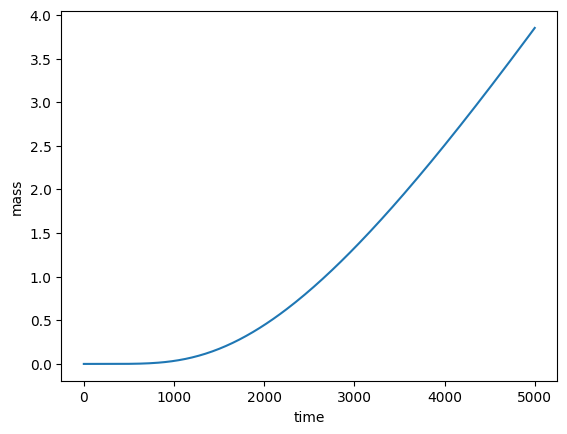

In [113]:
pyplot.xlabel("time")
pyplot.ylabel("mass")
pyplot.plot(tPoints, mPoints)
pyplot.show()